# Классификация и градиентные спуски

В этой тетрадке мы попробуем немного посмотреть на то, как работают разные градиентные спуски. 

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch                     # Низкоуровневые штуки
import torch.nn as nn            # Высокоуровневые штуки
import torch.nn.functional as F  # Тоже высокоуровневые штуки, но с интерфейсом функций, а не классов

# 1. Выборка

Делать всё это мы будем на животных. Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [2]:
X_path = Path('X_cat.csv')
y_path = Path('y_cat.csv')

if not X_path.exists():
    !wget -q https://github.com/dniku/neural_nets_dpo/raw/master/week04/X_cat.csv -O $X_path

if not y_path.exists():
    !wget -q https://github.com/dniku/neural_nets_dpo/raw/master/week04/y_cat.csv -O $y_path

In [3]:
X = pd.read_csv('X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('y_cat.csv', sep = '\t', index_col=0, header=None, names=['status'])['status']

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,Domestic,Shorthair,Longhair,Year,Month,Day,Hour,Breed_Chihuahua Shorthair Mix,Breed_Domestic Medium Hair Mix,Breed_Domestic Shorthair Mix,Breed_German Shepherd Mix,Breed_Labrador Retriever Mix,Breed_Pit Bull Mix,Breed_Rare,Sex_Female,Sex_Male,Sex_Unknown,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,0,0,0,2014,2,12,14.366667,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,1,1,0,2013,10,13,8.733333,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,0,0,0,2015,1,31,9.466667,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,1,1,0,2014,7,11,15.150000,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,0,0,0,2013,11,15,8.866667,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 37 фичей. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [4]:
target.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставить четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [5]:
target[target == 'Died'] = 'Euthanasia'

target.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1752
Name: status, dtype: int64

Закодируем классы.

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)

print(dict(zip(range(len(le.classes_)), le.classes_)))
print(y)

{0: 'Adoption', 1: 'Euthanasia', 2: 'Return_to_owner', 3: 'Transfer'}
[2 1 0 ... 0 3 3]


Разобьём выборку на тренировочную и тестовую. 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape)
print(X_valid.shape)

(21383, 37)
(5346, 37)


Отшкалируем данные. Если это не сделать, модель будет учиться хуже.

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_valid = ss.transform(X_valid)

# 2. Архитектурка

Соберём что-то простенькое и более-менее с потолка.

In [15]:
def make_new_model():
    dim_in = X_train.shape[1]
    dim_out = len(le.classes_)

    torch.manual_seed(42)
    
    model = nn.Sequential(
        nn.Linear(dim_in, 25),
        nn.ReLU(),
        nn.Linear(25, 25),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(25, dim_out),
    )
    
    return model

print(make_new_model())

Sequential(
  (0): Linear(in_features=37, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=4, bias=True)
)


# 3. Данные

Завернём датасет в даталоадер, чтобы бесплатно получить перемешивание и нарезку на батчи.

In [23]:
def prepare_data(X, y, batch_size=1000, shuffle=False):
    torch.manual_seed(123)

    X_torch = torch.tensor(X.values if isinstance(X, pd.DataFrame) else X, dtype=torch.float32)
    y_torch = torch.tensor(y, dtype=torch.int64)
    
    dataset = torch.utils.data.TensorDataset(X_torch, y_torch)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return X_torch, y_torch, dataset, loader

X_train_torch, y_train_torch, train_dataset, train_loader = prepare_data(X_train, y_train, shuffle=True)
X_valid_torch, y_valid_torch, valid_dataset, valid_loader = prepare_data(X_valid, y_valid)

# 4. Training loop

Решаем задачу классификации, поэтому в качестве лосса берём кросс-энтропию. Если будет время, в следующий раз напишем `CrossEntropyLoss` самостоятельно.

In [24]:
criterion = nn.CrossEntropyLoss()

Всё как в прошлый раз.

In [25]:
def train(model, opt, criterion, train_loader, valid_loader, num_epochs):
    # Заводим словарь, куда будем писать логи
    history = {'loss_train': [], 'loss_valid': []}
    
    with tqdm(range(num_epochs)) as progress_bar:
        for epoch in progress_bar:  # цикл по эпохам
            epoch_losses_train = []
            epoch_losses_valid = []

            for X_batch, y_batch in train_loader:  # цикл по train-датасету (его за нас перемешивает DataLoader)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                
                # Посчитайте градиенты и сделайте шаг оптимизатора (он передаётся в функцию параметром opt)
                opt.zero_grad()
                loss.backward()
                opt.step()

                # .item() конвертирует тензор из одного элемента в питоновское число
                epoch_losses_train.append(loss.item())

            with torch.no_grad():  # отключаем построение вычислительного графа на время валидации
                for X_batch, y_batch in valid_loader:  # цикл по valid-датасету
                    logits = model(X_batch)
                    loss = criterion(logits, y_batch)

                    epoch_losses_valid.append(loss.item())
            
            # Записываем логи
            history['loss_train'].append(np.mean(epoch_losses_train))
            history['loss_valid'].append(np.mean(epoch_losses_valid))
            
            # Обновляем прогресс-бар
            progress_bar.set_postfix_str(
                f'Train loss: {history["loss_train"][-1]:.3f}, ' +
                f'Validation loss: {history["loss_valid"][-1]:.3f}')

    return history

# 5. Эксперименты!

In [20]:
num_epochs = 500
learning_rate = 0.01

In [21]:
histories = {}

Функция для графиков:

In [22]:
def plot_history(histories):
    plt.figure(figsize=(16, 10))

    for name, history in histories.items():
        train = plt.plot(history['loss_train'], label=f'{name} train')
        plt.plot(history['loss_valid'], color=train[0].get_color(), linestyle='--', label=f'{name} valid')

    plt.xlabel('Epochs')
    plt.ylabel('Log loss')
    plt.legend()
    plt.grid()

### SGD 

Как и раньше, используем класс `torch.optim.SGD`.

In [26]:
model = make_new_model()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
histories['SGD'] = train(model, opt, criterion, train_loader, valid_loader, num_epochs)

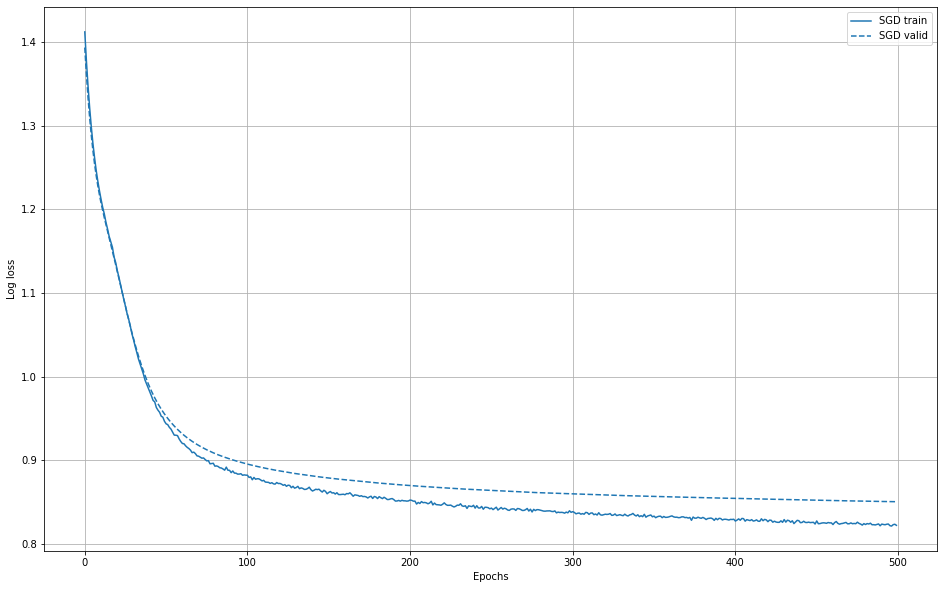

In [27]:
plot_history(histories)

### SGD with momentum

Снова используем `torch.optim.SGD`, но указываем параметр `momentum`.

In [28]:
model = make_new_model()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
histories['Momentum'] = train(model, opt, criterion, train_loader, valid_loader, num_epochs)

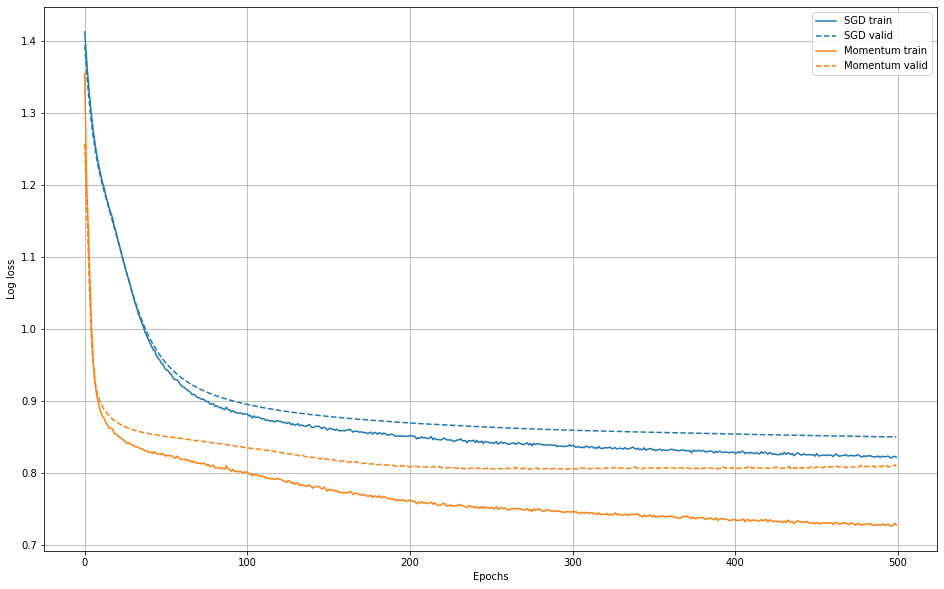

In [29]:
plot_history(histories)

### RMSprop 

Понадобится класс `torch.optim.RMSprop`.

In [30]:
model = make_new_model()
opt = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
histories['RMSProp'] = train(model, opt, criterion, train_loader, valid_loader, num_epochs)

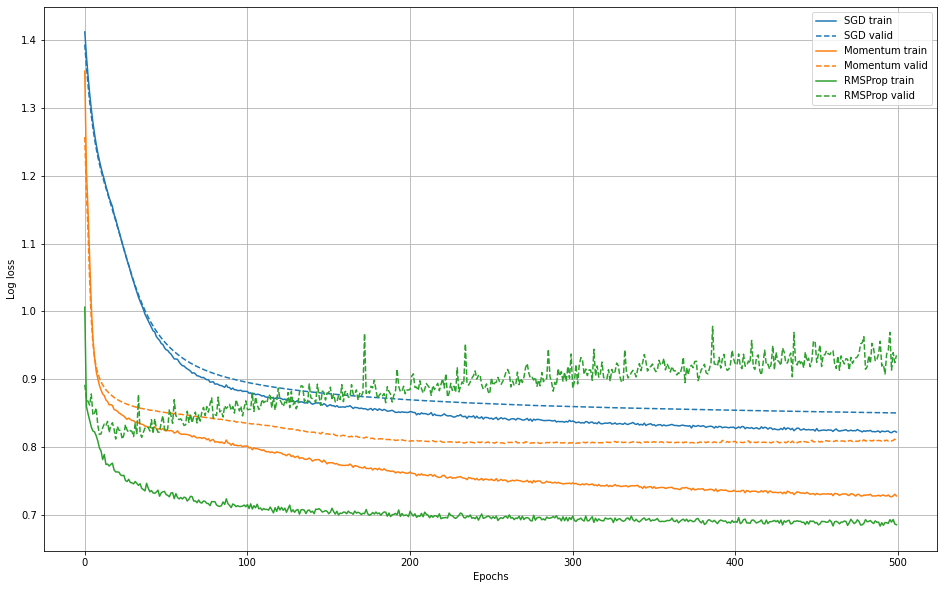

In [31]:
plot_history(histories)

### Adam 

Наконец, попробуем `torch.optim.Adam`.

In [32]:
model = make_new_model()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
histories['Adam'] = train(model, opt, criterion, train_loader, valid_loader, num_epochs)

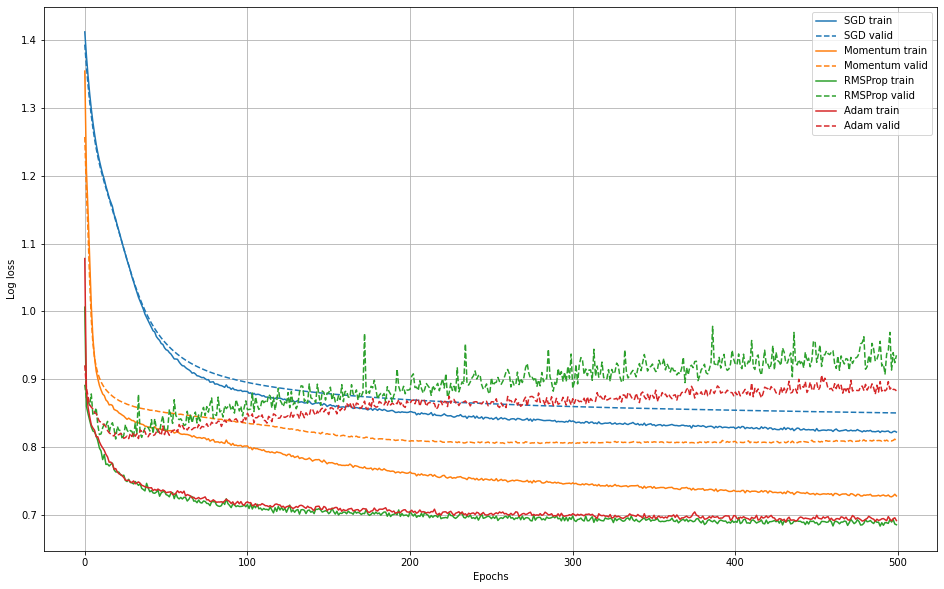

In [33]:
plot_history(histories)

# 6. Стратегии с постепенным понижением lr 

![](https://raw.githubusercontent.com/FUlyankin/neural_nets_econ/master/2019/sem_2/ahaha.jpg)

Попробуем уменьшать learning rate ступеньками: например, в 2 раза каждые 50 эпох. Для этого нам понадобится класс `torch.optim.lr_scheduler.StepLR`. Будем использовать его вместе с Адамом.

In [34]:
# Добавили параметр scheduler
def train(model, opt, scheduler, criterion, train_loader, valid_loader, num_epochs):
    history = {'loss_train': [], 'loss_valid': [], 'lr': []}  # будем записывать lr
    with tqdm(range(num_epochs)) as progress_bar:
        for epoch in progress_bar:
            epoch_losses_train = []
            epoch_losses_valid = []

            for X_batch, y_batch in train_loader:
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                opt.zero_grad()
                loss.backward()
                opt.step()
                
                epoch_losses_train.append(loss.item())

            with torch.no_grad():
                for X_batch, y_batch in valid_loader:
                    logits = model(X_batch)
                    loss = criterion(logits, y_batch)

                    epoch_losses_valid.append(loss.item())
                    
            history['loss_train'].append(np.mean(epoch_losses_train))
            history['loss_valid'].append(np.mean(epoch_losses_valid))
            
            # вызываем scheduler
            scheduler.step()
            
            # записываем lr
            history['lr'].append(opt.param_groups[0]['lr'])

            progress_bar.set_postfix_str(
                f'Train loss: {history["loss_train"][-1]:.3f}, ' +
                f'Validation loss: {history["loss_valid"][-1]:.3f}, ' +
                f'LR: {history["lr"][-1]:.5f}')  # показываем lr

    return history


model = make_new_model()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(opt, 50, gamma=0.5)
histories['Adam + StepLR'] = train(model, opt, scheduler, criterion, train_loader, valid_loader, num_epochs)

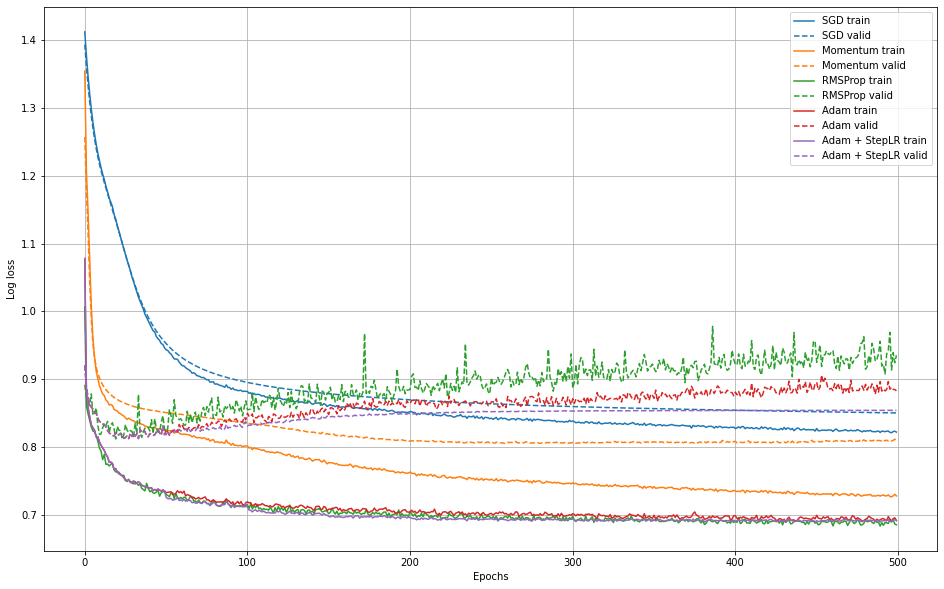

In [35]:
plot_history(histories)

In [36]:
# функция для картинок, чтобы видеть как скорость обучения меняется от эпохи к эпохе
def plot_learning_rate(loss_history):
    epochs = len(loss_history)
    plt.plot(range(1, epochs + 1), loss_history, label='learning rate')
    plt.xlabel("epoch")
    plt.xlim([1, epochs + 1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid()

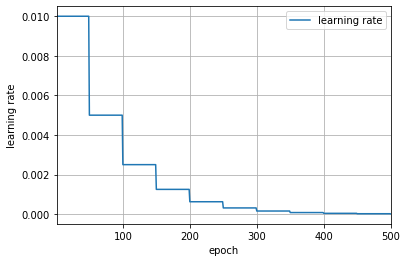

In [37]:
plot_learning_rate(histories['Adam + StepLR']['lr'])

Попробуем ещё вариант: `torch.optim.lr_scheduler.ReduceLROnPlateau`. Этот класс умножает learning rate на параметр `factor`, когда в течение `patience` эпох лосс на валидации не уменьшается.

In [41]:
def train(model, opt, scheduler, criterion, train_loader, valid_loader, num_epochs):
    history = {'loss_train': [], 'loss_valid': [], 'lr': []}
    with tqdm(range(num_epochs)) as progress_bar:
        for epoch in progress_bar:
            epoch_losses_train = []
            epoch_losses_valid = []

            for X_batch, y_batch in train_loader:
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                opt.zero_grad()
                loss.backward()
                opt.step()
                
                epoch_losses_train.append(loss.item())

            # with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                epoch_losses_valid.append(loss.item())
                    
            history['loss_train'].append(np.mean(epoch_losses_train))
            history['loss_valid'].append(np.mean(epoch_losses_valid))
                    
            scheduler.step(history['loss_valid'][-1])  # вызываем scheduler от валидационного лосса

            history['lr'].append(opt.param_groups[0]['lr'])

            progress_bar.set_postfix_str(
                f'Train loss: {history["loss_train"][-1]:.3f}, ' +
                f'Validation loss: {history["loss_valid"][-1]:.3f}, ' +
                f'LR: {history["lr"][-1]:.5f}')

    return history


model = make_new_model()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=10, verbose=True)
histories['Adam + ReduceLROnPlateau'] = train(
    model, opt, scheduler, criterion, train_loader, valid_loader, num_epochs)

Epoch   177: reducing learning rate of group 0 to 5.0000e-04.
Epoch   188: reducing learning rate of group 0 to 2.5000e-04.
Epoch   199: reducing learning rate of group 0 to 1.2500e-04.
Epoch   210: reducing learning rate of group 0 to 6.2500e-05.
Epoch   221: reducing learning rate of group 0 to 3.1250e-05.
Epoch   232: reducing learning rate of group 0 to 1.5625e-05.
Epoch   243: reducing learning rate of group 0 to 7.8125e-06.
Epoch   254: reducing learning rate of group 0 to 3.9063e-06.
Epoch   265: reducing learning rate of group 0 to 1.9531e-06.
Epoch   276: reducing learning rate of group 0 to 9.7656e-07.
Epoch   287: reducing learning rate of group 0 to 4.8828e-07.
Epoch   298: reducing learning rate of group 0 to 2.4414e-07.
Epoch   309: reducing learning rate of group 0 to 1.2207e-07.
Epoch   320: reducing learning rate of group 0 to 6.1035e-08.
Epoch   331: reducing learning rate of group 0 to 3.0518e-08.
Epoch   342: reducing learning rate of group 0 to 1.5259e-08.



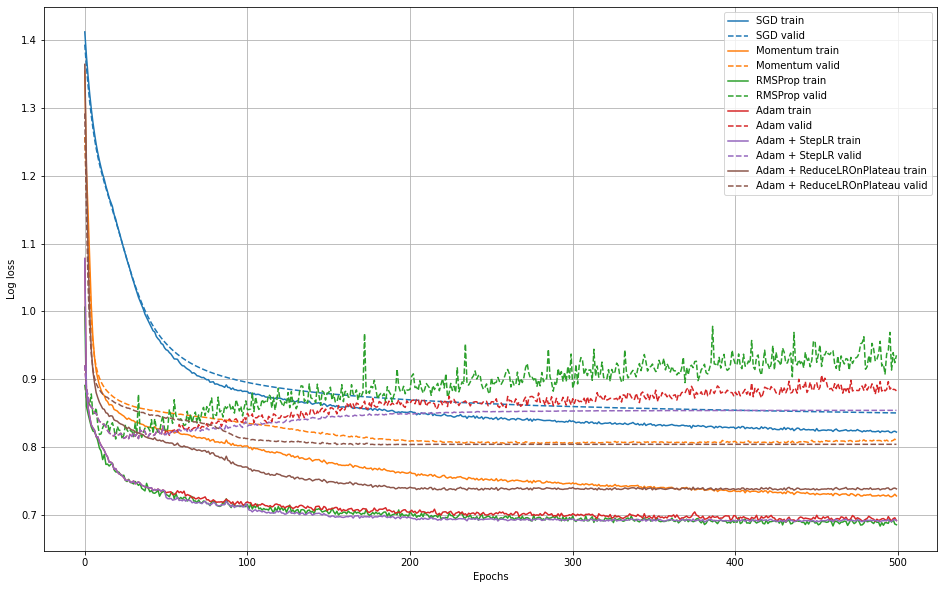

In [42]:
plot_history(histories)

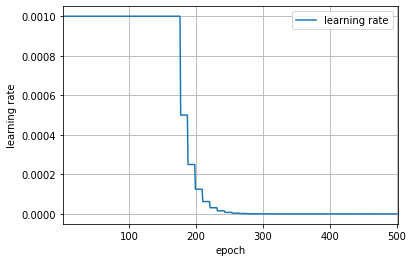

In [43]:
plot_learning_rate(histories['Adam + ReduceLROnPlateau']['lr'])

# 7. Что дальше?

* Другие расписания изменения скорости обучения (например, циклически меняющееся; для вдохновения см., например, [эту статью](https://www.jeremyjordan.me/nn-learning-rate/))
* Другая архитектура сетки (добавить слои или сделать глубже)
* ...

## Авторские права и почиташки 

Ноутбук основан на [ноутбуке](https://github.com/FUlyankin/neural_nets_dpo/blob/e296fc1/week03_grad/Keras_SGD_experiments_semisolve.ipynb) от Филиппа Ульянкина, который для его создания использовал [этот мануал](https://github.com/sukilau/Ziff-deep-learning/blob/master/3-CIFAR10-lrate/CIFAR10-lrate.ipynb).

# 8. Демо: что делает `no_grad`

В конце семинара обсудили, что `with torch.no_grad():` нужно для того, чтобы временно выключить построение вычислительного графа. Сравните результат выполнения следующих ячеек с `no_grad` и без него:

In [49]:
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        logits = model(X_batch)
        break

In [50]:
logits

tensor([[ 0.6548, -2.3076,  1.0596, -0.9076],
        [-0.2610, -1.4783, -1.5415,  0.8761],
        [-3.7449,  1.2097, -3.5424,  3.1467],
        ...,
        [-3.4573, -0.0687, -0.8289,  1.3962],
        [ 0.9383, -2.8824,  1.2283, -1.0317],
        [ 2.4561, -5.7565,  1.0596, -0.7657]])

In [51]:
loss = logits.sum()

In [52]:
loss.backward()

RuntimeError: ignored